# Market Segmentation for a French (C2C) Fashion Store

Market segmentation for a french (C2C) fashion store using cluster analysis to achieve more effective customer marketing via personalization.

The data source is 'data.world' portal https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store.  

The focus of the project is customers who are active users of the platform in selling field. To be consider as an active user, they should have at least one listed, sold, bought, liked or wishes product.    

Customers who follow common pattern of behaviour are segregate into 5 segments.  Moreover, 6 customers have stand out features, so they are treat apart from the clusters.

### Importing packages, loading the data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import collections

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import cluster, tree, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Disable zero division warnings
np.errstate(divide='ignore')

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

# Download the dataset
# Source https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
fl = '2. Prepared Data/6M-0K-99K.users.dataset.public.csv'
data = pd.read_csv(fl)

# Preview data
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9006282053848196165,user,Suède,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2858299215060733023,user,France,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr


## 1. Data Preprocessing

### 1.1. Exploratory Data Analysis & Data Cleaning

In [2]:
# Get base information on the dataset
data.columns

Index(['identifierHash', 'type', 'country', 'language', 'socialNbFollowers',
       'socialNbFollows', 'socialProductsLiked', 'productsListed',
       'productsSold', 'productsPassRate', 'productsWished', 'productsBought',
       'gender', 'civilityGenderId', 'civilityTitle', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'seniorityAsMonths', 'seniorityAsYears', 'countryCode'],
      dtype='object')

In [3]:
# Drop columns with information that will not be used or is duplicated 
drop_columns = ['civilityGenderId', 'civilityTitle', 'seniorityAsMonths', 'seniorityAsYears','countryCode']
data.drop(columns=drop_columns, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  hasAnyApp            98913 non-null  bool   
 14  hasAndroidApp        98913 non-null  bool   
 15  hasIosApp            98913 non-null 

In [4]:
# Get the dimensionality of the dataset
print(data.shape)

(98913, 19)


In [5]:
# Check that user identification numbers are unique
users = len(data['identifierHash'].unique().tolist())
print(f'Duplicated users: {users-data.shape[0]}')

# Chech type of users is 'user' 
user_types = (data['type']=='user').sum() - data.shape[0]

# Drop 'type' column if type of all users is 'user' 
if user_types==0:
    data.drop(columns='type', inplace=True)
    
# Drop rows if type of users is different from 'user'
# Then drop 'type' column
else:
    other_types = data['type']!='user'
    data.drop(data[other_types].index, inplace=True)
    data.drop(columns='type', inplace=True)

Duplicated users: 0


In [6]:
# Check duplicated rows
print(f'Duplicated rows : {data.duplicated().sum()}')
# Find missing values 
print(f'Missing values: {data.isnull().sum().sum()}')

Duplicated rows : 0
Missing values: 0


In [7]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numeric_cols = data.select_dtypes([np.int64,np.float64]).columns.tolist()
print (f'Numeric: {len(numeric_cols)} \n{numeric_cols}')

categorical_cols = data.select_dtypes([np.object]).columns.tolist()
print (f'Categorical: {len(categorical_cols)} \n{categorical_cols}')

booleans_cols = data.select_dtypes([np.bool]).columns.tolist()
print (f'Boolean: {len(booleans_cols)} \n{booleans_cols}')

Columns
Numeric: 11 
['identifierHash', 'socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority']
Categorical: 3 
['country', 'language', 'gender']
Boolean: 4 
['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture']


In [8]:
# Filter data of active users, who sold, bought, wished or liked products

###################################### FILTER ################################################

# List of columns related to user activity in selling of products
products = ['socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought']
# Calculate sum across rows
data['productSum'] = data[products].sum(axis=1)

# Filter data of user who have any activity (sum > 0)
data = data[data['productSum'] > 0]

# Drop utility 'productSum' column
data.drop(columns='productSum', inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

# Preview data
data.head()

,identifierHash,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority
0,-7877915015908472168,Royaume-Uni,en,3,8,4,0,0,0.0,0,0,F,False,False,False,True,591,3205
1,-8231936648814680895,Danemark,en,3,8,370,0,0,0.0,1,0,F,False,False,False,True,42,3205
2,5663923945758514393,Etats-Unis,en,3,8,1,0,0,0.0,0,0,F,False,False,False,True,32,3205
3,-3483039296670050121,Allemagne,de,3,8,27,0,0,0.0,0,0,M,True,False,True,True,669,3205
4,3451396970677435825,Suisse,en,3,8,0,0,0,0.0,9,0,F,True,True,False,True,463,3205


In [9]:
# Get the dimensionality of the dataset
print(data.shape)

(21639, 18)


In [10]:
# Get statistics for numeric columns
data.drop(columns='identifierHash').describe() 

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniority
count,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,3063.934979
std,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,168.278417
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2852.000000
25%,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,2857.000000
50%,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,3196.000000
75%,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,3201.000000
max,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,3205.000000


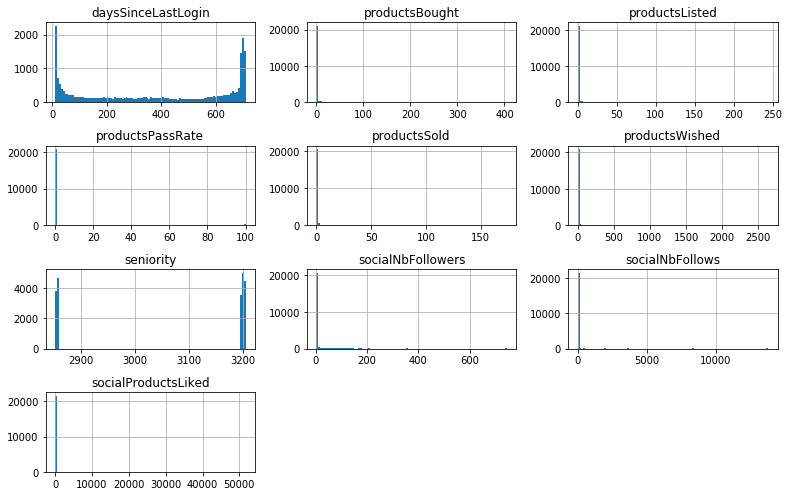

In [11]:
# Plot the distribution of numerical columns

# Create list of numerical columns for plots
# Copy the list of numerical columns
numeric_cols_plot = numeric_cols.copy()
# Remove the 'identifierHash' column
numeric_cols_plot.remove('identifierHash')
# Plot histograms
data[numeric_cols_plot].hist(figsize=(11,7), bins=100)
plt.tight_layout()

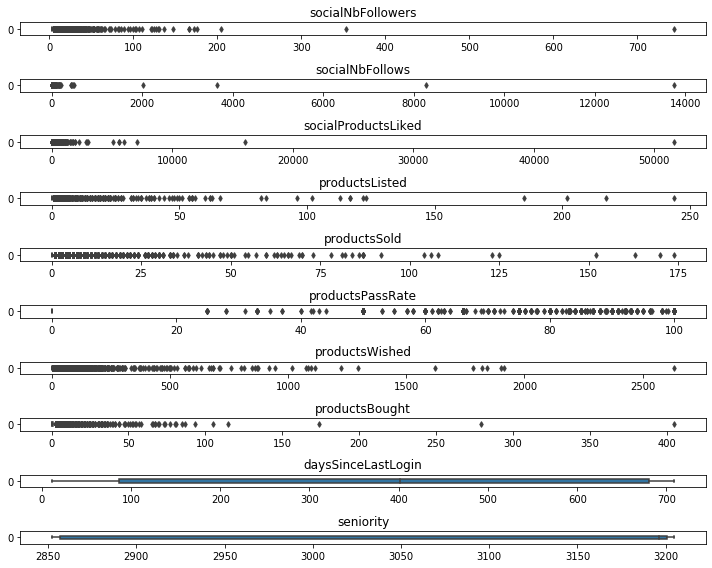

In [12]:
# Plot boxplots

fig, axes = plt.subplots(nrows=len(numeric_cols_plot),ncols=1,figsize=(10,8))
for index, column in enumerate(numeric_cols_plot):
    ax=sns.boxplot(data=data[column],orient='h', ax=axes[index], width=0.3, fliersize=4, color=color)
    ax.set_title(data[column].name)

plt.tight_layout()

In [13]:
# Generate pairplot
#sns.pairplot(data[numeric_cols].drop(columns=drop_num_cols))

Text(0.5, 1, 'Correlation Matrix')

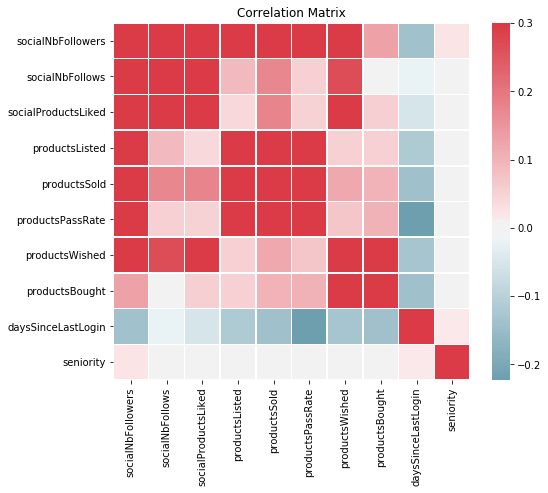

In [14]:
# Generate our corelation plot or heatmap
corr = data[numeric_cols_plot].corr()
# Generate heatmap
plt.figure(figsize = (8,8))
cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Correlation Matrix')

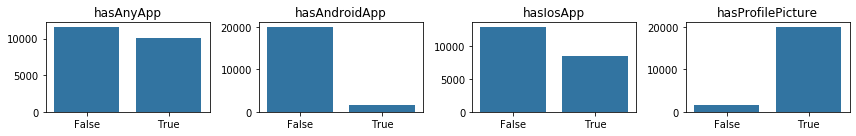

In [15]:
# Plot booleans data
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2))
for index, column in enumerate(booleans_cols):
    ax=sns.countplot(x=data[column],orient='h', ax=axes[index], color=color)
    ax.set_title(data[column].name)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

In [16]:
# Plot categorical data
# Count number of countries
countries_number = len(data['country'].unique().tolist())
print(f'Countries: {countries_number}')

# Translate the list of countries into English 
data['country'] = data['country'].replace({
     'Royaume-Uni':'UK', 'Danemark':'Denmark','Etats-Unis':'US', 'Allemagne':'Germany', 
     'Suisse':'Swiss','Suède':'Sweden','Australie':'Australia','Italie':'Italy', 'Espagne':'Spain', 
     'Finlande':'Finland','Belgique':'Belgium','Pays-Bas':'Netherlands', 'Autriche':'Austria', 
    'Russie':'Russia', 'Bulgarie':'Bulgaria', 'Chine':'China', 'Irlande': 'Ireland', 'Roumanie':'Romania'})

# Group users by country
countries=pd.DataFrame(data['country'].value_counts()).sort_values(by='country',ascending=False)
countries.rename(columns={'country':'users'}, inplace=True)
# Calculate % of total users by country
countries['users_%_total'] = round(countries['users']/countries['users'].sum(),3)*100

# Number of users by country
users_20 = countries.head(20)
users_20

Countries: 127


,users,users_%_total
France,4972,23.0
US,3927,18.1
UK,2555,11.8
Italy,1993,9.2
Germany,1835,8.5
Spain,1048,4.8
Australia,631,2.9
Denmark,614,2.8
Sweden,497,2.3
Netherlands,482,2.2


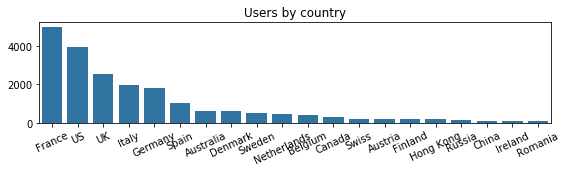

In [17]:
# Plot categorical data
fig, ax1 = plt.subplots(figsize=(8,2.5))

sns.barplot(x=users_20.index, y=users_20['users'], color=color, ax=ax1)

ax1.set_title('Users by country')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.xaxis.set_tick_params(rotation=25)

plt.tight_layout()

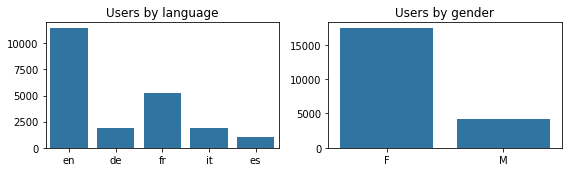

In [18]:
# Plot categorical data
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(8,2.5))

sns.countplot(x=data['language'],orient='h', color=color, ax=ax1)
sns.countplot(x=data['gender'],orient='h', color=color, ax=ax2)

ax1.set_title('Users by language')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_title('Users by gender')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()

In [19]:
# Selling by country
selling_filter = (data['productsListed']==0) & (data['productsSold']==0)
selling_data = data[~selling_filter]
selling_data_group=selling_data.groupby('country')[['productsSold', 'productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).reset_index()
selling_data_group['%sold']=round(selling_data_group[('productsSold', 'sum')]/selling_data_group[('productsSold', 'sum')].sum(),3)*100
selling_data_group['%listed']=round(selling_data_group[('productsListed', 'sum')]/selling_data_group[('productsListed', 'sum')].sum(),3)*100
selling_top10=selling_data_group.nlargest(10,('productsSold', 'sum'))
# Start the index from 1
selling_top10.index=selling_top10.index+1
print('Products sold by top 10 countries')
selling_top10

Products sold by top 10 countries


,country,productsSold,productsListed,%sold,%listed
,,sum,sum,,
1,France,3014,2242,25.1,24.3
2,Italy,2820,2401,23.4,26.0
3,UK,1806,1025,15.0,11.1
4,Spain,990,667,8.2,7.2
5,US,967,962,8.0,10.4
6,Germany,536,349,4.5,3.8
7,Sweden,336,237,2.8,2.6
8,Netherlands,214,157,1.8,1.7
9,Monaco,190,27,1.6,0.3


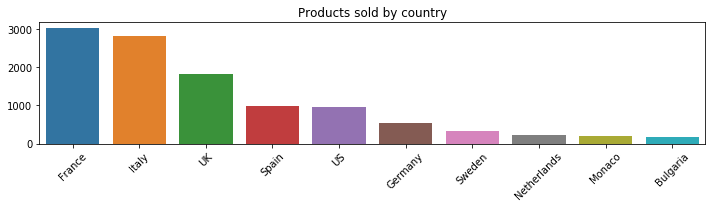

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=selling_top10['country'],y=selling_top10[('productsSold', 'sum')])
ax.set_title('Products sold by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [21]:
# Verification Selling
#data.groupby('country')[[ 'productsSold','productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).T

In [22]:
# Buying by country
buying_filter = (data['socialProductsLiked']==0) & (data['productsWished']==0) & (data['productsBought']==0)
buying_data = data[~buying_filter]
buying_data_group=buying_data.groupby('country')[['productsBought','socialProductsLiked', 'productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).reset_index()
buying_data_group['%bought']=round(buying_data_group[('productsBought', 'sum')]/buying_data_group[('productsBought', 'sum')].sum(),3)*100
buying_data_group['%liked']=round(buying_data_group[('socialProductsLiked', 'sum')]/buying_data_group[('socialProductsLiked', 'sum')].sum(),3)*100
buying_data_group['%wished']=round(buying_data_group[('productsWished', 'sum')]/buying_data_group[('productsWished', 'sum')].sum(),3)*100
buying_top10=buying_data_group.nlargest(10,('productsBought', 'sum'))
# Start the index from 1
buying_top10.index=buying_top10.index+1
print('Products bought by top 10 countries')
buying_top10

Products bought by top 10 countries


,country,productsBought,socialProductsLiked,productsWished,%bought,%liked,%wished
,,sum,sum,sum,,,
1,France,3573,55969,21790,21.0,12.8,14.1
2,US,2370,54090,17567,13.9,12.4,11.4
3,UK,2174,35199,18469,12.8,8.0,11.9
4,Germany,1635,33568,15477,9.6,7.7,10.0
5,Italy,1221,85239,17264,7.2,19.5,11.2
6,Spain,1028,26213,10245,6.0,6.0,6.6
7,Belgium,718,5164,4083,4.2,1.2,2.6
8,Sweden,566,20539,6743,3.3,4.7,4.4
9,Netherlands,537,10669,3934,3.2,2.4,2.5


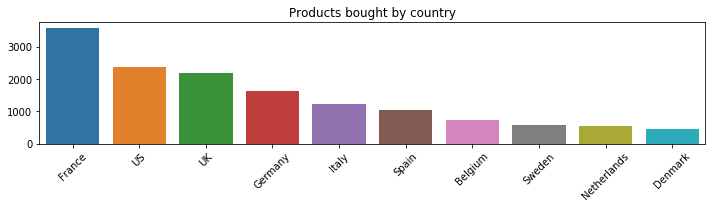

In [23]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=buying_top10['country'],y=buying_top10[('productsBought', 'sum')])
ax.set_title('Products bought by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [24]:
# Verification Buying
#data.groupby('country')[['productsBought','socialProductsLiked','productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).T

### 1.2. Feature Engineering

In [25]:
# Define countries as 'Other', if % of users is less then 1%
users_perc_lim = 1
other_countries = countries[countries['users_%_total']<users_perc_lim].index.tolist()
print(f'Other countries: {len(other_countries)}')
#print(other_countries)
data['country_short_list']=data['country'].apply(lambda x: 'Other' if x in other_countries else x)
countries_list = data['country_short_list'].unique().tolist()
print(f'Countries short list: {countries_list}')

Other countries: 114
Countries short list: ['UK', 'Denmark', 'US', 'Germany', 'Swiss', 'France', 'Other', 'Sweden', 'Canada', 'Australia', 'Italy', 'Spain', 'Belgium', 'Netherlands']


In [26]:
# Save the initial data to use with results of clustering
data_origin = data.copy()
data_origin.head()

,identifierHash,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,country_short_list
0,-7877915015908472168,UK,en,3,8,4,0,0,0.0,0,0,F,False,False,False,True,591,3205,UK
1,-8231936648814680895,Denmark,en,3,8,370,0,0,0.0,1,0,F,False,False,False,True,42,3205,Denmark
2,5663923945758514393,US,en,3,8,1,0,0,0.0,0,0,F,False,False,False,True,32,3205,US
3,-3483039296670050121,Germany,de,3,8,27,0,0,0.0,0,0,M,True,False,True,True,669,3205,Germany
4,3451396970677435825,Swiss,en,3,8,0,0,0,0.0,9,0,F,True,True,False,True,463,3205,Swiss


In [27]:
# Change the boolean column type to integer
data[booleans_cols]=data[booleans_cols].astype(int)

# Duplicate columns
data['language_c']=data['language']
# Convert categorical variable into dummy/indicator variables
cat_features =['language', 'gender', 'country_short_list']
data = pd.get_dummies(data, columns=cat_features)

# Rename columns
data.rename(columns={'language_c': 'language'}, inplace=True)

# Preview data
data.drop(columns=['identifierHash']).head()

# Check that 'hasAnyApp' is 'hasAndroidApp' or 'hasIosApp'
(data['hasAndroidApp']+data['hasIosApp']-data['hasAnyApp']).isnull().sum()

0

In [28]:
# Save the preprocessed data to a csv file
file = '2. Prepared Data/classification_e-commerce_preprocessed_data.csv'
data.to_csv(file, index = False)
data.shape

(21639, 38)

In [29]:
def get_model_parameters(model_name, results_list):
    """ Returns a list of patameters that is relevant to the highest silhoette score. """
    # Initiate a dictionary to save a silhoette score and index from the list of parameters
    coeff = {}
    # Loop through the list of parameters
    for index,result in enumerate(results_list):
        # Save index and silhoette coefficient to the list
        coeff.update({result[0] : index})
    
    # Find out the highest silhoette coefficient
    max_coeff = max(coeff.keys())
    
    # Find out the List of patameters that is relevant to the best score
    results = results_list[coeff.get(max_coeff)]
            
    # Return the list of patameters that is relevant to the highest silhoette score
    return results

def print_model_parameters(model_name, results_list):
    """ Prints model's name and parameters in form: '# [Silhoette Coefficient, eps, min_smpl, n_clusters]'. """
    print(model_name)
    print(f'# [Silhoette Coefficient, eps, min_smpl, n_clusters]')
    
    for index,result in enumerate(results_list):
        print(index, result)
    
def print_model_n_clusters_parameter(model_name, results_list):
    """ Prints model's name and a n_clusters parameter in form: '# [Silhoette Coefficient, n_clusters]'. """
    print(model_name)
    print(f'# [Silhoette Coefficient, n_clusters]')
    
    for index,result in enumerate(results_list):
        print(index, result)

## 2. Clustering

### 2.1. Features 

In [30]:
data.columns

Index(['identifierHash', 'country', 'socialNbFollowers', 'socialNbFollows',
       'socialProductsLiked', 'productsListed', 'productsSold',
       'productsPassRate', 'productsWished', 'productsBought', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'language', 'language_de', 'language_en', 'language_es',
       'language_fr', 'language_it', 'gender_F', 'gender_M',
       'country_short_list_Australia', 'country_short_list_Belgium',
       'country_short_list_Canada', 'country_short_list_Denmark',
       'country_short_list_France', 'country_short_list_Germany',
       'country_short_list_Italy', 'country_short_list_Netherlands',
       'country_short_list_Other', 'country_short_list_Spain',
       'country_short_list_Sweden', 'country_short_list_Swiss',
       'country_short_list_UK', 'country_short_list_US'],
      dtype='object')

In [31]:
features = ['productsListed', 'productsSold', 'productsBought', 
            'productsWished','socialProductsLiked','socialNbFollowers','socialNbFollows',
            'daysSinceLastLogin']


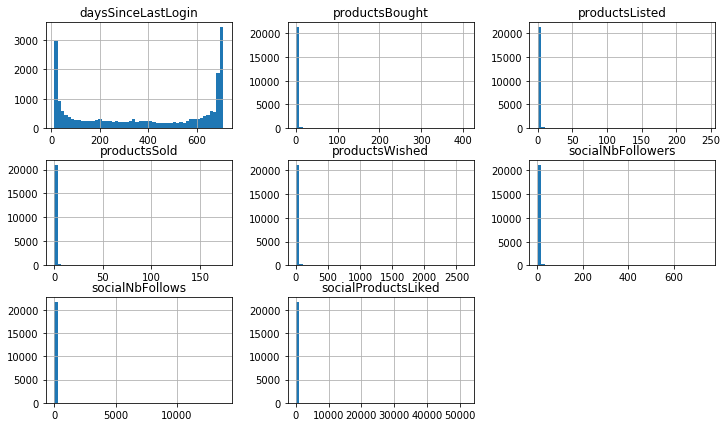

In [32]:
data[features].hist(figsize=(12,7), bins =50)
plt.show()

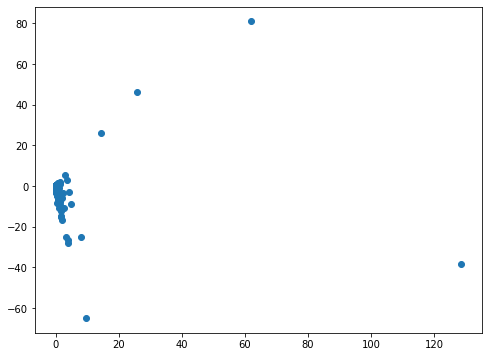

In [33]:
# Set up the data
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl[features])

df_scl['x']=df_pca[:,0]
df_scl['y']=df_pca[:,1]

plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

In [34]:
# Pick out the most significant outliers
#outliers = df_scl[(df_scl['y']>20) | (df_scl['y']<-20)]
outliers = df_scl[df_scl['x']>7]
data.loc[outliers.index]

,identifierHash,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
8197,2119852871524485845,France,353,8268,5595,5,15,66.0,875,0,1,0,1,0,31,3198,fr,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10975,3718185418791028367,Italy,744,13764,51671,0,104,85.0,1842,0,1,0,1,0,14,3195,it,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11096,4083881020900546640,France,205,2013,35,3,1,0.0,4,0,1,1,0,0,45,3195,en,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
12275,4020093783926093303,Denmark,57,9,16040,0,0,0.0,11,8,1,0,1,0,11,2859,en,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17558,3275083886092943154,Sweden,125,500,7044,117,67,90.0,664,0,0,0,0,0,16,2855,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21614,8317887111506061089,France,107,3649,310,217,70,98.0,0,0,1,0,1,1,11,3204,fr,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [35]:
# Drop the selected outliers
droped_outliers = data.loc[outliers.index]

# Save the clustered data to a csv file
file = '4. Analysis/droped_outliers_classification_e-commerce_clusters.csv'
droped_outliers.to_csv(file, index = False)

data.drop(outliers.index, inplace=True)
print(data.shape)

(21633, 38)


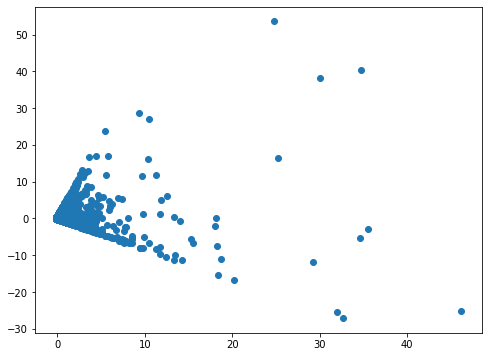

In [36]:
# Set up the data
df_scl=data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl[features] = RobustScaler().fit_transform(df_scl)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl[features])

plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

### 2.2. A Base Model

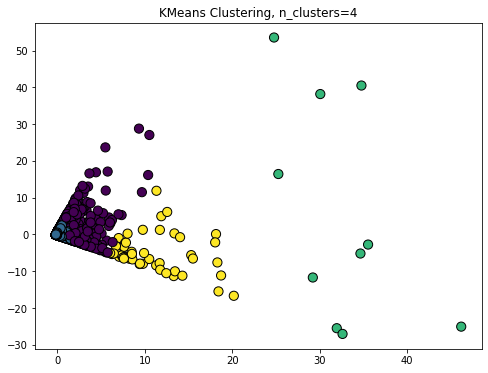

KMeans Clustering:
n_clusters=4, Silhouette Coefficient: 0.9103974982709198
Clusters: Counter({1: 21176, 0: 396, 3: 51, 2: 10})


In [37]:
# Set up the data
df = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

# ---------------------------------- KMeans Clustering ------------------------------------------
# A number of clusters
n_clusters=4
# KMeans model
km = KMeans(n_clusters=n_clusters, max_iter=500, random_state=None).fit(df_scl)
labels = km.labels_

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering, n_clusters={n_clusters}')
plt.show()

print('KMeans Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(df_scl, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

In [38]:
print('Base Model:')
print(km)

Base Model:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


### 2.3. Model Selection

In [39]:
# Set up the data
df = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- KMeans Clustering ------------------------------------------
model_name = 'KMeans'

# Initiate a list of results
results_list = []

# Loop through the range of a number of clusters
clusters = range(2, 8)
for index, n_cluster in enumerate(clusters):
    # Fit a model
    kmeans = KMeans(n_clusters=n_cluster, max_iter=500).fit(X)
    labels = kmeans.labels_
    # Get a silhouette score
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    # Save a silhouette score and a number of clusters into a list
    results_list.append([sil_coeff,n_cluster])

kmean_results_list = results_list    

# ---------------------------------- End KMeans Clustering ------------------------------------------

In [40]:
# Set up the data
df = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- DBSCAN Clustering ------------------------------------------
model_name = 'DBSCAN'

# Initiate a list of results
results_list = []

for e in [6,6.5,7, 7.5, 8,8.5,9]:
       
    # The number of samples (or total weight)
    min_smpl = 5
    # Instantiate a DBSCAN Model, fit the model
    dbscan = DBSCAN(eps=e, min_samples = min_smpl, metric='manhattan').fit(X)
    # Store labels formed by the DBSCAN
    labels = dbscan.labels_

    # Number of clusters
    n_clusters = len(set(labels)) - ( 1 if -1 in labels else 0)
    # Silhouette Score
    sil_coeff= silhouette_score(X, labels, metric='euclidean')
    # Save results to the list
    results_list.append([sil_coeff,e, min_smpl, n_clusters])

dbscan_results_list = results_list       

 # ---------------------------------- End DBSCAN Clustering ------------------------------------------


In [41]:
# Set up the data
df = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- Agglomerative Clustering ------------------------------------------
model_name = 'Agglomerative Clustering'

# Initiate a list of results
results_list = []

# Loop through the range of a number of clusters
clusters = range(2, 8)
for index, n_cluster in enumerate(clusters):
    # Fit a model
    aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward').fit(X)
    labels = aggl.labels_
    n_cluster = aggl.n_clusters_
    # Get a silhouette score
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    # Save a silhouette score and a number of clusters into a list
    results_list.append([sil_coeff,n_cluster])

aggl_results_list = results_list    

# ---------------------------------- End Agglomerative Clustering ------------------------------------------ 

In [42]:
# ----------------------------- Results of model evaluation ------------------------------------------------

#---------------------------------- Kmeans -----------------------------------------------------------------
model_name = 'KMeans'
# Print the list of patameters
print_model_n_clusters_parameter(model_name, kmean_results_list)

# Get the best model parameters
param_kmeans = get_model_parameters(model_name, kmean_results_list)
print(f'The best Kmeans parameters: {param_kmeans}')

# Select the best parameter
# Select the best parameter when n_clusters > 2
param_kmeans_n_clusters = 5

print(f'Selected Kmeans parameters: n_clusters = {param_kmeans_n_clusters}')
#----------------------------------- DBSCAN ---------------------------------------------------------------
model_name = 'DBSCAN'
# Print the list of patameters
print_model_parameters(model_name, dbscan_results_list)

# Get the best model parameters
param_dbscan = get_model_parameters(model_name, dbscan_results_list)
print(f'The best DBSCAN parameters: {param_dbscan}')
  
print(f'Selected DBSCAN parameters: {param_dbscan}')

# ---------------------------------- Agglomerative Clustering ---------------------------------------------
model_name = 'Agglomerative Clustering'
print_model_n_clusters_parameter(model_name, aggl_results_list)

# Get the best model parameters
param_aggl = get_model_parameters(model_name, aggl_results_list)
print(f'The best Agglomerative Clustering parameters: {param_aggl}')

# Select the best parameter
# Select the best parameter when n_clusters > 2 and silhouette score is highest before it drops
param_param_aggl_n_clusters = 5

print(f'Selected Agglomerative Clustering parameters: n_clusters = {param_param_aggl_n_clusters}')

KMeans
# [Silhoette Coefficient, n_clusters]
0 [0.9782758940972757, 2]
1 [0.9427807781658666, 3]
2 [0.9103974982709198, 4]
3 [0.9105358246306514, 5]
4 [0.8985103971847738, 6]
5 [0.9010700622300798, 7]
The best Kmeans parameters: [0.9782758940972757, 2]
Selected Kmeans parameters: n_clusters = 5
DBSCAN
# [Silhoette Coefficient, eps, min_smpl, n_clusters]
0 [0.720594207195568, 6, 5, 3]
1 [0.7511978765540787, 6.5, 5, 5]
2 [0.7819535566058281, 7, 5, 6]
3 [0.834246839777478, 7.5, 5, 4]
4 [0.8206378134880522, 8, 5, 4]
5 [0.7433005670777205, 8.5, 5, 5]
6 [0.743406290786861, 9, 5, 5]
The best DBSCAN parameters: [0.834246839777478, 7.5, 5, 4]
Selected DBSCAN parameters: [0.834246839777478, 7.5, 5, 4]
Agglomerative Clustering
# [Silhoette Coefficient, n_clusters]
0 [0.9722393454395899, 2]
1 [0.963775335657795, 3]
2 [0.8988814379094386, 4]
3 [0.8990193944098179, 5]
4 [0.8880587748595528, 6]
5 [0.8886992485237261, 7]
The best Agglomerative Clustering parameters: [0.9722393454395899, 2]
Selected Ag

In [43]:
param_kmeans_n_clusters, param_dbscan, param_param_aggl_n_clusters

(5, [0.834246839777478, 7.5, 5, 4], 5)

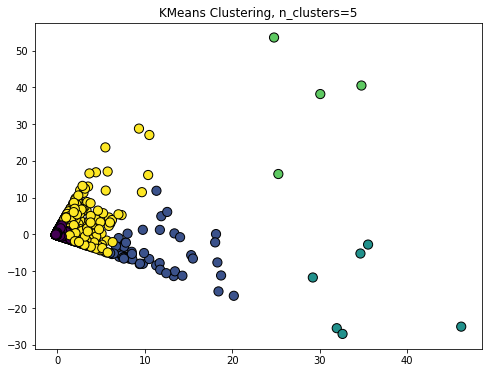

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
n_clusters=5, Silhouette Coefficient: 0.9105358246306514
Clusters: Counter({0: 21176, 4: 396, 1: 51, 2: 6, 3: 4})


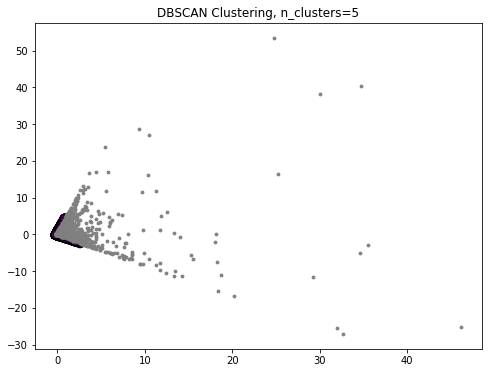

DBSCAN(algorithm='auto', eps=9, leaf_size=30, metric='manhattan',
       metric_params=None, min_samples=5, n_jobs=None, p=None)
n_clusters=5, Silhouette Coefficient: 0.743406290786861
Clusters: Counter({0: 20739, -1: 865, 1: 13, 3: 6, 4: 5, 2: 5})


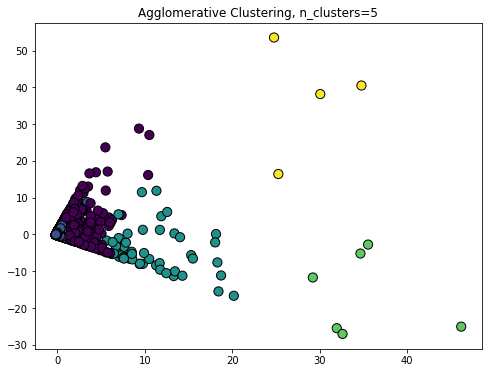

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)
n_clusters=5, Silhouette Coefficient: 0.8990193944098179
Clusters: Counter({1: 21102, 0: 468, 2: 53, 3: 6, 4: 4})


In [44]:
# Set up the data
df = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

df['x'] = df_pca[:,0]
df['y'] = df_pca[:,1]

# Scaled data
X = df_scl
#---------------------------------- Kmeans -------------------------------------------------
kmeans = KMeans(n_clusters=param_kmeans_n_clusters, max_iter=500).fit(X)
labels = kmeans.labels_
n_clusters = len(set(labels))
df['kmeans']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering, n_clusters={n_clusters}')
plt.show()

print(kmeans)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')
#----------------------------------- DBSCAN ----------------------------------------------------
dbscan = DBSCAN(eps=e, min_samples = min_smpl, metric='manhattan').fit(X)
labels = dbscan.labels_
n_clusters = len(set(labels)) - ( 1 if -1 in labels else 0)
df['dbscan']=labels

# Plot the result
plt.figure(figsize=(8,6))

# Plot the clustered data
clust = df['dbscan']!=-1
data_cl = df.loc[clust]
#plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)
plt.scatter(data_cl['x'], data_cl['y'], c=data_cl['dbscan'], edgecolors='k', s=84)

# Plot the noise
outl = df['dbscan']==-1
data_outl = df.loc[outl]
#plt.scatter(df_pca[:,0],df_pca[:,1], c='grey', edgecolors='grey', s=8)
plt.scatter(data_outl['x'], data_outl['y'], c='grey', edgecolors='grey', s=8)

plt.title(f'DBSCAN Clustering, n_clusters={n_clusters}')
plt.show()

print(dbscan)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')
# ---------------------------------- Agglomerative Clustering -------------------------------------
aggl = AgglomerativeClustering(n_clusters=param_param_aggl_n_clusters, affinity='euclidean', linkage='ward').fit(X)
labels = aggl.labels_
n_clusters = len(set(labels))
df['aggl']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering, n_clusters={n_clusters}')
plt.show()

print(aggl)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

In [45]:
# Save the results of clustering to a csv file
print(f'data_origin: {df.shape}')
print(f'df: {df.shape}')

# Add cluster labels and PCA components to the original DataFrame
result = data_origin.merge(df[['x', 'y', 'kmeans', 'dbscan', 'aggl']],how='outer', left_index=True,right_index=True)
print(f'Result: {result.shape}')

# Save the clustered data to a csv file
file = '5. Insights/classification_e-commerce_clusters.csv'
result.to_csv(file, index = False)

data_origin: (21633, 13)
df: (21633, 13)
Result: (21639, 24)


### 2.4. The Final Model

KMeans and Agglomerative Clustering give almost the same silhouette soefficient and distribution of samples for 5 clusters.
KMeans clustering shows the highest silhouette soefficient, and clusters are a bit more clearly separated on the scatter plot. 
So that KMeans(n_clusters=5, max_iter=500) is considered as the final model.

Final Model:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


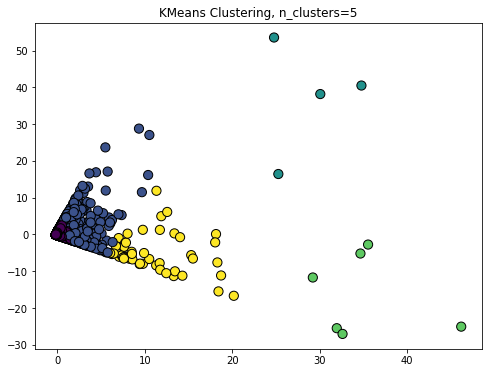

n_clusters=5, Silhouette Coefficient: 0.9105358246306514
Clusters: Counter({0: 21176, 1: 396, 4: 51, 3: 6, 2: 4})


In [46]:
# Set up the data
df_f = data[features].copy()

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df_scl = RobustScaler().fit_transform(df_f)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

df['x'] = df_pca[:,0]
df['y'] = df_pca[:,1]

# Scaled data
X = df_scl
#---------------------------------- Kmeans -------------------------------------------------
kmeans = KMeans(n_clusters=param_kmeans_n_clusters, max_iter=500, random_state=None).fit(X)
labels = kmeans.labels_
n_clusters = len(set(labels))
df['kmeans']=labels

print('Final Model:')
print(kmeans)

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering, n_clusters={n_clusters}')
plt.show()

# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

## 3. Profile of clusters

In [47]:
#file = '5. Insights/classification_e-commerce_clusters.csv'
#result= pd.read_csv(file)

In [48]:
result.head()

,identifierHash,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,country_short_list,x,y,kmeans,dbscan,aggl
0,-7877915015908472168,UK,en,3,8,4,0,0,0.0,0,0,F,False,False,False,True,591,3205,UK,-0.152663,-0.042293,0.0,0.0,1.0
1,-8231936648814680895,Denmark,en,3,8,370,0,0,0.0,1,0,F,False,False,False,True,42,3205,Denmark,0.739294,3.761487,0.0,0.0,1.0
2,5663923945758514393,US,en,3,8,1,0,0,0.0,0,0,F,False,False,False,True,32,3205,US,-0.159750,-0.073432,0.0,0.0,1.0
3,-3483039296670050121,Germany,de,3,8,27,0,0,0.0,0,0,M,True,False,True,True,669,3205,Germany,-0.097666,0.197585,0.0,0.0,1.0
4,3451396970677435825,Swiss,en,3,8,0,0,0,0.0,9,0,F,True,True,False,True,463,3205,Swiss,-0.013553,-0.208986,0.0,0.0,1.0


In [49]:
# Clusters labels from the final model
model_clusters = 'kmeans'
# Count a number of samples in clusters
result[model_clusters].value_counts()

0.0    21176
4.0      396
1.0       51
2.0        6
3.0        4
Name: kmeans, dtype: int64

In [50]:
# Create a DataFrame with features and labels of the clusters
clusters = result[features + [model_clusters]].groupby(model_clusters).mean()

# Count a number of samples in clusters and convert result to a DataFrame
labels_sum = pd.DataFrame(result[model_clusters].value_counts())

# Add sum of clusters as column to the clusters DataFrame
clusters_sum = pd.concat([clusters, labels_sum], axis=1)

# Find mean for columns, convert the result to a DataFrame and transpose it  
total_mean =pd.DataFrame(result[features ].mean(), columns=['mean']).T

# Add means as a row to the DataFrame with cluster data
print('CLUSTERS')
pd.concat([clusters_sum, total_mean])

CLUSTERS


,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin,kmeans
0.0,0.360644,0.464583,0.558982,2.811012,9.096760,4.253400,8.348838,391.315215,21176.0
1.0,3.784314,7.333333,18.196078,604.686275,311.882353,19.137255,19.235294,23.960784,51.0
2.0,1.833333,1.000000,91.500000,1946.000000,994.166667,31.833333,124.833333,36.666667,6.0
3.0,0.750000,2.500000,19.250000,1028.000000,4930.750000,23.750000,13.250000,27.000000,4.0
4.0,2.633838,3.893939,9.108586,113.666667,308.957071,14.388889,19.416667,77.904040,396.0
mean,0.426498,0.555802,0.785896,7.142705,20.207450,4.557558,9.911271,384.445631,NaN


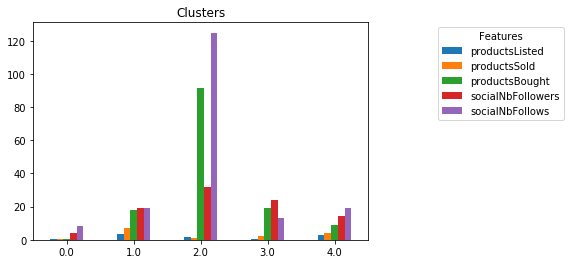

In [51]:
# Plot clusters features
sales = ['productsListed', 'productsSold', 'productsBought', 'socialNbFollowers', 'socialNbFollows']
fig, ax = plt.subplots(figsize=(6,4))
clusters[sales].plot.bar(rot=0, ax=ax)
ax.set_title('Clusters')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Features', bbox_to_anchor=(0.5, 0.5, 1.1, 0.5))

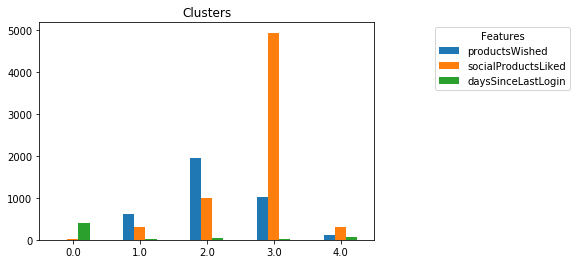

In [52]:
produsts = ['productsWished','socialProductsLiked', 'daysSinceLastLogin']
fig, ax = plt.subplots(figsize=(6,4))
clusters[produsts].plot.bar(rot=0, ax=ax)
ax.set_title('Clusters')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Features', bbox_to_anchor=(0.5, 0.5, 1.1, 0.5))

In [53]:
result[result[model_clusters]==0][features].describe()

,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin
count,21176.000000,21176.000000,21176.000000,21176.000000,21176.000000,21176.000000,21176.000000,21176.000000
mean,0.360644,0.464583,0.558982,2.811012,9.096760,4.253400,8.348838,391.315215
std,3.806679,3.823246,2.878675,8.546062,25.446007,4.630438,2.359018,269.578372
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,11.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,100.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,412.000000
75%,0.000000,0.000000,0.000000,2.000000,6.000000,4.000000,8.000000,681.250000
max,244.000000,170.000000,279.000000,109.000000,370.000000,167.000000,122.000000,709.000000


In [54]:
result[result[model_clusters]==1][features].describe()

,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,3.784314,7.333333,18.196078,604.686275,311.882353,19.137255,19.235294,23.960784
std,11.298343,22.179871,21.114942,215.674522,416.344792,19.805070,23.246151,51.960354
min,0.000000,0.000000,0.000000,368.000000,1.000000,3.000000,0.000000,11.000000
25%,0.000000,0.000000,4.000000,444.000000,25.500000,8.500000,8.000000,11.000000
50%,0.000000,0.000000,10.000000,519.000000,106.000000,12.000000,10.000000,11.000000
75%,1.500000,2.000000,27.000000,709.000000,466.000000,23.500000,26.000000,15.000000
max,63.000000,108.000000,105.000000,1225.000000,1728.000000,121.000000,157.000000,369.000000


In [55]:
result[result[model_clusters]==2][features].describe()

,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin
count,6.000000,6.00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.833333,1.00,91.500000,1946.000000,994.166667,31.833333,124.833333,36.666667
std,3.544949,2.00,154.661889,353.598077,856.947937,8.612007,186.052054,39.149287
min,0.000000,0.00,2.000000,1622.000000,2.000000,19.000000,8.000000,11.000000
25%,0.000000,0.00,19.250000,1792.250000,267.500000,26.250000,12.250000,12.000000
50%,0.500000,0.00,38.000000,1860.000000,1054.500000,36.000000,36.500000,20.500000
75%,1.000000,0.75,49.250000,1912.000000,1703.500000,36.750000,145.500000,40.250000
max,9.000000,5.00,405.000000,2635.000000,1929.000000,40.000000,482.000000,112.000000


In [56]:
result[result[model_clusters]==3][features].describe()

,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin
count,4.000000,4.0,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000
mean,0.750000,2.5,19.250000,1028.000000,4930.75000,23.750000,13.250000,27.000000
std,0.957427,3.0,14.863266,279.672427,1311.75617,8.261356,5.057997,23.508864
min,0.000000,0.0,5.000000,634.000000,3037.00000,18.000000,9.000000,12.000000
25%,0.000000,0.0,11.750000,973.000000,4591.00000,19.500000,9.000000,14.250000
50%,0.500000,2.0,16.000000,1091.500000,5353.50000,20.500000,12.500000,17.000000
75%,1.250000,4.5,23.500000,1146.500000,5693.25000,24.750000,16.750000,29.750000
max,2.000000,6.0,40.000000,1295.000000,5979.00000,36.000000,19.000000,62.000000


In [57]:
result[result[model_clusters]==4][features].describe()

,productsListed,productsSold,productsBought,productsWished,socialProductsLiked,socialNbFollowers,socialNbFollows,daysSinceLastLogin
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.00000
mean,2.633838,3.893939,9.108586,113.666667,308.957071,14.388889,19.416667,77.90404
std,9.578444,14.316985,17.046944,84.294571,377.822791,20.862789,43.418664,142.85140
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,11.00000
25%,0.000000,0.000000,1.000000,40.500000,41.750000,5.000000,8.000000,11.00000
50%,0.000000,0.000000,3.000000,110.500000,195.000000,8.000000,9.000000,13.00000
75%,0.000000,1.000000,10.000000,165.000000,439.750000,14.000000,13.000000,50.50000
max,96.000000,174.000000,174.000000,351.000000,2942.000000,176.000000,450.000000,700.00000
